# Backtesting with bt

### Table of Contents
- [Preface](#preface)
- [Construct dataset](#construct)
- [Define strategies](#define)
- [Run backtest](#run)
- [Evaluate backtest](#evaluate)

### Preface <a name="preface"></a>

Backtesting is used to evaluate the historical performance and risk of investment strategies. Backtesting shows us how an investment strategy would have performed if implemented in the past. After backtesting several strategies, an investor may choose their preferred strategy based on their own investment goals and risk tolerance.

To conduct a backtest, you need a dataset of historical adjusted prices for assets you are considering to add to your portfolio. The data set needs to span the time range and include the assets that you are interested in.

Let's use [polygon.io](https://polygon.io/) for the financial data used in this demo. Their [API](https://polygon.io/docs/) is free to use if you have a brokerage account with [Alpaca](https://alpaca.markets/). The assets we will consider investing in are ETFs from Vanguard that cover equities within different industries in the United States, including technology, healthcare, and financial services. The ETFs I consider for my portfolio are:

- VGT: Information Technology
- VNQ: Real Estate
- VHT: Healthcare
- VFH: Financials
- VDC: Consumer Staples
- VOX: Communication Services
- VDE: Energy
- VIS: Industrials
- VAW: Materials
- VPU: Utilities
- VCR: Consumer Discretionary

### Construct dataset <a name="construct"></a>

In [1]:
import requests
import json
import time
import pandas as pd
import numpy as np
import pytz
import bt
from datetime import datetime

%matplotlib inline

C:\Users\14072\anaconda3\lib\site-packages\ffn\core.py:27: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)


In [2]:
# retrieve alpaca keys
# this defines a variable named KEY_ID, which contains my Alpaca Key ID
%run alpaca_keys.py

In [3]:
multiplier = '1'
date_start = '2006-01-01'
date_end = '2020-07-30'
timespan = 'day'

tickers = ['VGT', 'VNQ', 'VHT', 'VFH', 'VDC', 'VOX', 'VDE', 'VIS', 'VAW', 'VPU', 'VCR']

price_dict = {}
price_dict.update({'t': pd.DataFrame(requests.get(f'https://api.polygon.io/v2/aggs/ticker/VGT/range/{multiplier}/{timespan}/{date_start}/{date_end}?apiKey={KEY_ID}').json()['results'])['t']})
for ticker in tickers:
    request_string = f'https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{multiplier}/{timespan}/{date_start}/{date_end}?apiKey={KEY_ID}'
    price_dict.update({ticker: pd.DataFrame(requests.get(request_string).json()['results'])['c']})
    
prices_df = pd.DataFrame(price_dict)
 
est = pytz.timezone('US/Eastern')
utc = pytz.utc
prices_df.index = [datetime.utcfromtimestamp(ts / 1000.).replace(tzinfo=utc).astimezone(est).date() for ts in prices_df['t']]
prices_df.index.name = 'Date'
prices_df.drop('t', axis=1, inplace=True)

#### Take a look at the prices dataframe. Each column represents the price of an asset. Each row represents the adjusted closing price of the asset for a day.

In [4]:
prices_df.head()

,VGT,VNQ,VHT,VFH,VDC,VOX,VDE,VIS,VAW,VPU,VCR
Date,,,,,,,,,,,
2006-01-03,49.28,60.76,54.56,56.83,56.15,54.85,75.40,57.52,61.0300,66.3700,52.9200
2006-01-04,49.93,61.21,55.13,56.88,56.48,55.39,76.00,58.13,61.3901,66.6300,52.9601
2006-01-05,50.39,61.68,55.13,57.15,56.19,55.47,74.95,57.98,61.5000,66.1299,52.9900
2006-01-06,51.19,62.26,55.50,57.36,56.36,55.89,76.60,58.45,62.1600,66.6500,53.4300
2006-01-09,51.41,62.79,55.86,57.66,56.69,55.94,76.71,58.75,62.2900,66.5700,53.9200


In [5]:
# convert prices to daily returns in case I'd like to analyze this later
r_df = prices_df.pct_change().dropna()

# convert returns to hypothetical prices if each asset price started at $100
pdf = 100*np.cumprod(1+r_df)

# Change index to pandas Timestamps
prices_df.index = [pd.Timestamp(x) for x in prices_df.index]
pdf.index = [pd.Timestamp(x) for x in pdf.index]

#### Plot the relative performance of each asset over time

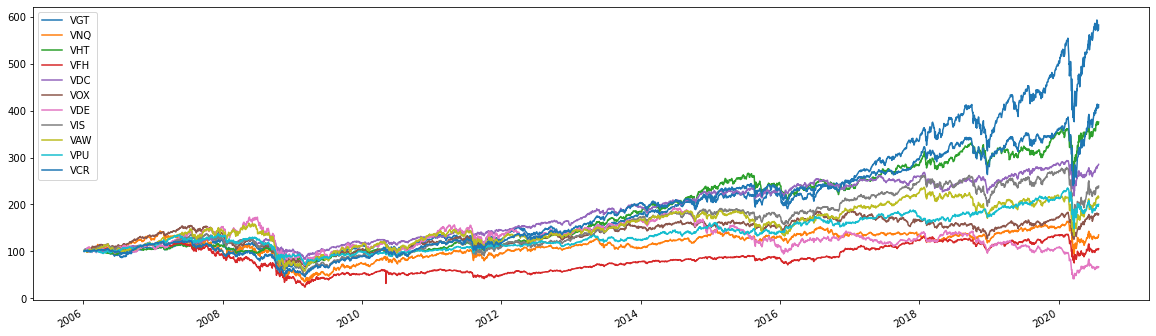

In [6]:
pdf.plot(figsize=(20,6))

### Define multiple investment strategies <a name="define"></a>

**Strategy 1:** Assign equal portfolio weights for each asset. Rebalance the portfolio every year.

In [7]:
s1 = bt.Strategy(
    name='EW',
    algos=[
        bt.algos.RunYearly(),
        bt.algos.SelectAll(),
        bt.algos.WeighEqually(),
        bt.algos.Rebalance()]
)
test1 = bt.Backtest(s1, prices_df, integer_positions=False)

**Strategy 2:** Assign portfolio weights that are proportional to the inverse of the asset's variance over the past 90 days. Rebalance every quarter.

In [8]:
s2 = bt.Strategy(
    name='InverseVol', 
    algos=[
        bt.algos.RunQuarterly(),
        bt.algos.SelectAll(),
        bt.algos.WeighInvVol(lookback=pd.DateOffset(days=90)),
        bt.algos.Rebalance()]
)
test2 = bt.Backtest(s2, prices_df, integer_positions=False)

**Strategy 3:** Assign portfolio weights to make each asset contribute an equal amount of risk to the portfolio. Rebalance every quarter.

In [9]:
s3 = bt.Strategy(
    name='EqualRisk', 
    algos=[
        bt.algos.RunQuarterly(),
        bt.algos.SelectHasData(lookback=pd.DateOffset(days=90)),
        bt.algos.WeighERC(lookback=pd.DateOffset(days=90)),
        bt.algos.Rebalance()]
)
test3 = bt.Backtest(s3, prices_df, integer_positions=False)

**Strategy 4:** Assign portfolio weights to maximize expected returned normalized by variance. Rebalance every month.

In [10]:
s4 = bt.Strategy(
    name='MeanVarOpt', 
    algos=[
        bt.algos.RunMonthly(),
        bt.algos.SelectHasData(lookback=pd.DateOffset(days=90)),
        bt.algos.WeighMeanVar(lookback=pd.DateOffset(days=90), rf=0),
        bt.algos.Rebalance()]
)
test4 = bt.Backtest(s4, prices_df, integer_positions=False)

**Strategy 5:** Assign constant weights for a subset of the assets. 60% to tech, 20% to healthcare, and 20% to industrials. Rebalance every month.

In [11]:
# tickers = ['VGT', 'VNQ', 'VHT', 'VFH', 'VDC', 'VOX', 'VDE', 'VIS', 'VAW', 'VPU', 'VCR']
# 60% to VGT, 20% to VHT, and 20% to VIS
weights_s5 = pd.Series([0.6, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0], index=tickers)
s5 = bt.Strategy(
    name='TechHeavy', 
    algos=[
        bt.algos.RunMonthly(),
        bt.algos.SelectAll(),
        bt.algos.WeighSpecified(**weights_s5),
        bt.algos.Rebalance()]
)
test5 = bt.Backtest(s5, prices_df, integer_positions=False)

**Strategy 6:** Invest in assets above their 50-day moving average.

In [12]:
# Consider all assets where the price is above its 50-day moving average and weight them equally in your portfolio.
# Rebalance monthly

# Daily, find all assets that have prices above their 50-day moving average.
# Among this subset, assign weights equally. 

ma50 = pdf.rolling(50).mean()
s6 = bt.Strategy(
    name='Above50MA', 
    algos=[
        bt.algos.RunDaily(run_on_first_date=False),
        bt.algos.SelectWhere(pdf > ma50),
        bt.algos.WeighEqually(),
        bt.algos.Rebalance()]
)
test6 = bt.Backtest(s6, prices_df, integer_positions=False)

**Strategy 7:** Invest in assets when their 50-day moving average crosses above their 200-day moving average.

In [13]:
# Moving average cross over strategy.
# When the 50-day moving average crosses above the 200-day moving average,
# purchase that stock.
# When it cross back, sell.

ma50 = pdf.rolling(50).mean()
ma200 = pdf.rolling(200).mean()
tw = ma200.copy()
# hold a position in an asset when its 50-day moving average is above its 200-day moving average
tw[ma50 > ma200] = 1
tw[ma50 <= ma200] = 0.0
tw[ma200.isnull()] = 0.0

# make each row sum to 1 (or 0 if no assets meet criteria)
tw = tw.div(tw.sum(axis=1), axis=0, )

ma_cross = bt.Strategy('50MA_crossover',
                       [bt.algos.WeighTarget(tw),
                        bt.algos.Rebalance()])

test7 = bt.Backtest(ma_cross, prices_df, integer_positions=False)

### Run the backtests <a name="run"></a>

In [14]:
res = bt.run(test1, test2, test3, test4, test5, test6, test7)

EW
0% [############################# ] 100% | ETA: 00:00:00InverseVol
0% [############################# ] 100% | ETA: 00:00:00EqualRisk
0% [############################# ] 100% | ETA: 00:00:00MeanVarOpt
0% [############################# ] 100% | ETA: 00:00:00TechHeavy
0% [############################# ] 100% | ETA: 00:00:00Above50MA
0% [############################# ] 100% | ETA: 00:00:0050MA_crossover
0% [############################# ] 100% | ETA: 00:00:00

### Evaluate the strategies' returns <a name="evaluate"></a>

In [15]:
res.stats

,EW,InverseVol,EqualRisk,MeanVarOpt,TechHeavy,Above50MA,50MA_crossover
start,2006-01-02 00:00:00,2006-01-02 00:00:00,2006-01-02 00:00:00,2006-01-02 00:00:00,2006-01-02 00:00:00,2006-01-02 00:00:00,2006-01-02 00:00:00
end,2020-07-29 00:00:00,2020-07-29 00:00:00,2020-07-29 00:00:00,2020-07-29 00:00:00,2020-07-29 00:00:00,2020-07-29 00:00:00,2020-07-29 00:00:00
rf,0,0,0,0,0,0,0
total_return,1.35146,1.40735,1.33489,0.41379,3.62101,0.57975,0.997956
cagr,0.0604373,0.0621483,0.0599227,0.0240495,0.110762,0.0318799,0.0486469
max_drawdown,-0.567306,-0.532787,-0.538476,-0.568478,-0.538424,-0.586809,-0.424358
calmar,0.106534,0.116647,0.111282,0.0423051,0.205715,0.0543276,0.114637
mtd,0.0595475,0.0599404,0.0594197,0.0855855,0.0425548,0.0612227,0.0626883
three_month,0.100377,0.100791,0.099148,0.105875,0.145914,0.118887,0.0769004
six_month,-0.0460252,-0.023334,-0.0271871,-0.0452183,0.0529977,0.0688847,-0.104116


#### Compare performance across strategies for different time periods

In [16]:
res.display_lookback_returns()

,EW,InverseVol,EqualRisk,MeanVarOpt,TechHeavy,Above50MA,50MA_crossover
mtd,5.95%,5.99%,5.94%,8.56%,4.26%,6.12%,6.27%
3m,10.04%,10.08%,9.91%,10.59%,14.59%,11.89%,7.69%
6m,-4.60%,-2.33%,-2.72%,-4.52%,5.30%,6.89%,-10.41%
ytd,-4.26%,-1.74%,-1.88%,-3.43%,9.34%,7.61%,-9.24%
1y,0.70%,3.23%,3.29%,-0.65%,18.99%,8.99%,-4.23%
3y,4.45%,5.19%,4.87%,0.45%,17.73%,4.17%,3.91%
5y,5.56%,6.10%,5.79%,-1.30%,15.50%,6.51%,3.38%
10y,9.08%,9.61%,9.34%,5.26%,16.08%,9.01%,7.90%
incep,6.04%,6.21%,5.99%,2.40%,11.08%,3.19%,4.86%


#### Plot the portfolio values over time

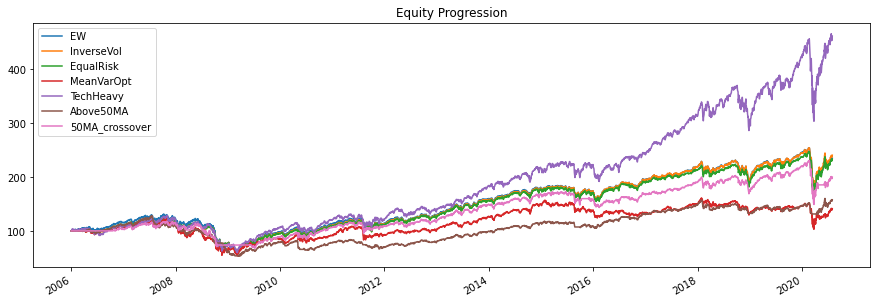

In [17]:
res.plot()

#### Plot the security weights over time for a strategy

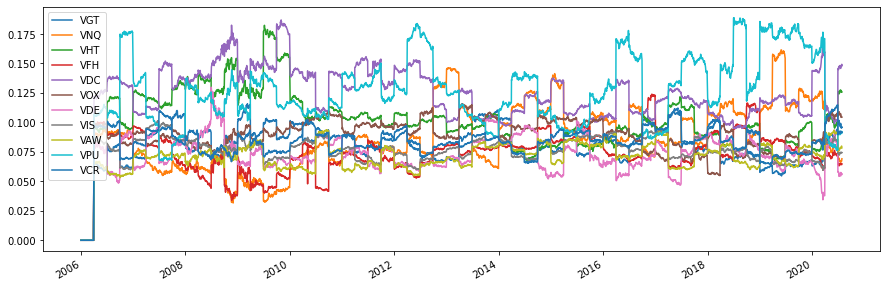

In [18]:
res.plot_security_weights(backtest='EqualRisk')

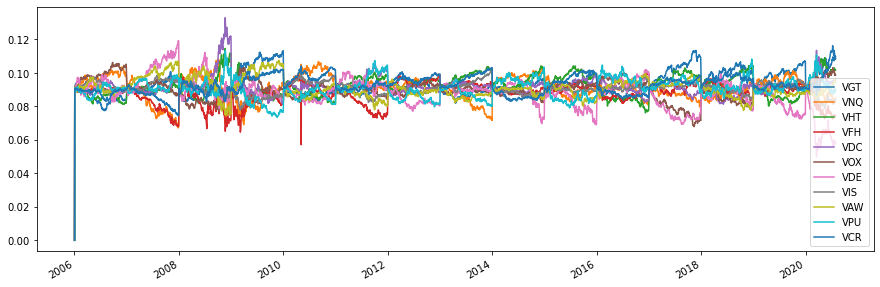

In [19]:
res.plot_security_weights(backtest='EW')

#### Plot correlations between the strategies' returns

<module 'matplotlib.pyplot' from 'C:\\Users\\14072\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

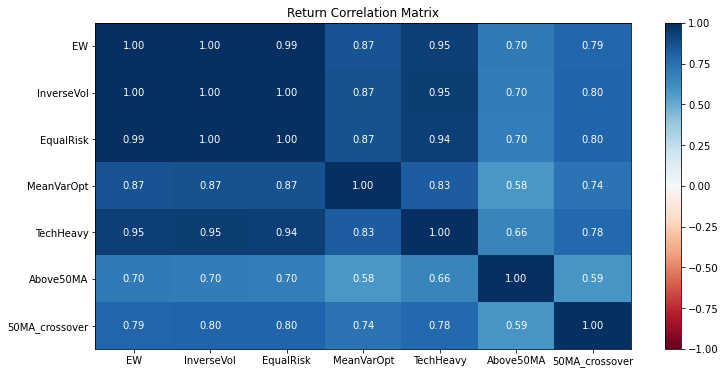

In [20]:
res.plot_correlation()

#### Retrieve all transactions from a strategy

In [21]:
res.get_transactions(strategy_name='TechHeavy')

price      quantity
Date       Security                      
2006-01-03 VGT        49.28  12175.324675
           VHT        54.56   3665.689150
           VIS        57.52   3477.051460
2006-02-01 VGT        50.59    -32.726385
           VHT        55.38     31.759072
...                     ...           ...
2020-06-01 VHT       195.06    171.208483
           VIS       128.52      3.787018
2020-07-01 VGT       279.37   -247.680838
           VHT       194.10    196.769685
           VIS       128.97    240.378381

[525 rows x 2 columns]